In [1]:
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls
from ptycho_functions import RAAR_loop, mPIE_loop_cupy,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, plot_guess_and_model, get_circular_mask

ModuleNotFoundError: No module named 'pyfftw'

In [ ]:
def get_simulated_data(probe_steps_xy,random_positions=True,use_bad_points=False, add_position_errors=False,object_offset = 50,dimension = 100):

    """ Create Probe """
    # dimension = 100 # Must be < than object!
    mask = get_circular_mask(dimension,0.5)
    probe = np.load('data/probe80.npy')*mask

    positionsX,positionsY = get_positions_array(probe_steps_xy,probe.shape,random_positions)

    """ Create object """
    # phase = np.array( np.load('data/star_phase.npy')) # Load Imagem
    # magnitude = np.array( np.load('data/star.npy')) # Load Imagem
    phase = np.array( np.load('data/gravel128.npy')) # Load Imagem
    magnitude = np.array( np.load('data/camera128.npy')) # Load Imagem
    
    phase = np.pi*phase/np.max(phase)
    magnitude = magnitude/np.max(magnitude)
    model_object = np.abs(magnitude)*np.exp(1j*phase)

    
    model_object = set_object_frame(positionsY, positionsX,model_object,probe,object_offset,'',save=False)

    print('Model object:',model_object.shape)
    print('Probe: ',probe.shape)
    
    
    difpads = []
    for px,py in zip(positionsX,positionsY):
    
        """ Exit wave-field """
        W = model_object[py:py+dimension,px:px+dimension]*probe
    
        """ Propagation """
        difpad = np.fft.fft2(W)
        difpad = np.fft.fftshift(difpad)
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
        
        # misc.imshow(np.abs(difpad),(5,5),savename='difpadgrid.png')
        # plt.show()
        # plt.close()

        difpads.append(difpad)

    positions = np.hstack((np.array([positionsX]).T ,np.array([positionsY]).T)) # adjust positions format for proper input
    difpads = np.asarray(difpads)
    
    if add_position_errors:
        max_error = 0.1*np.mean(positions)
        positions_errors = max_error*np.random.rand(*positions.shape)
        positions += positions_errors
        return difpads, positions, model_object, probe, positions_errors
    else:
        positions_errors = []
        return difpads, positions, model_object, probe, positions_errors

Model object: (152, 163)
Probe:  (80, 80)
Object pixel size: 2.1962328634132057e-08
Oversampling:  6.133479414913971


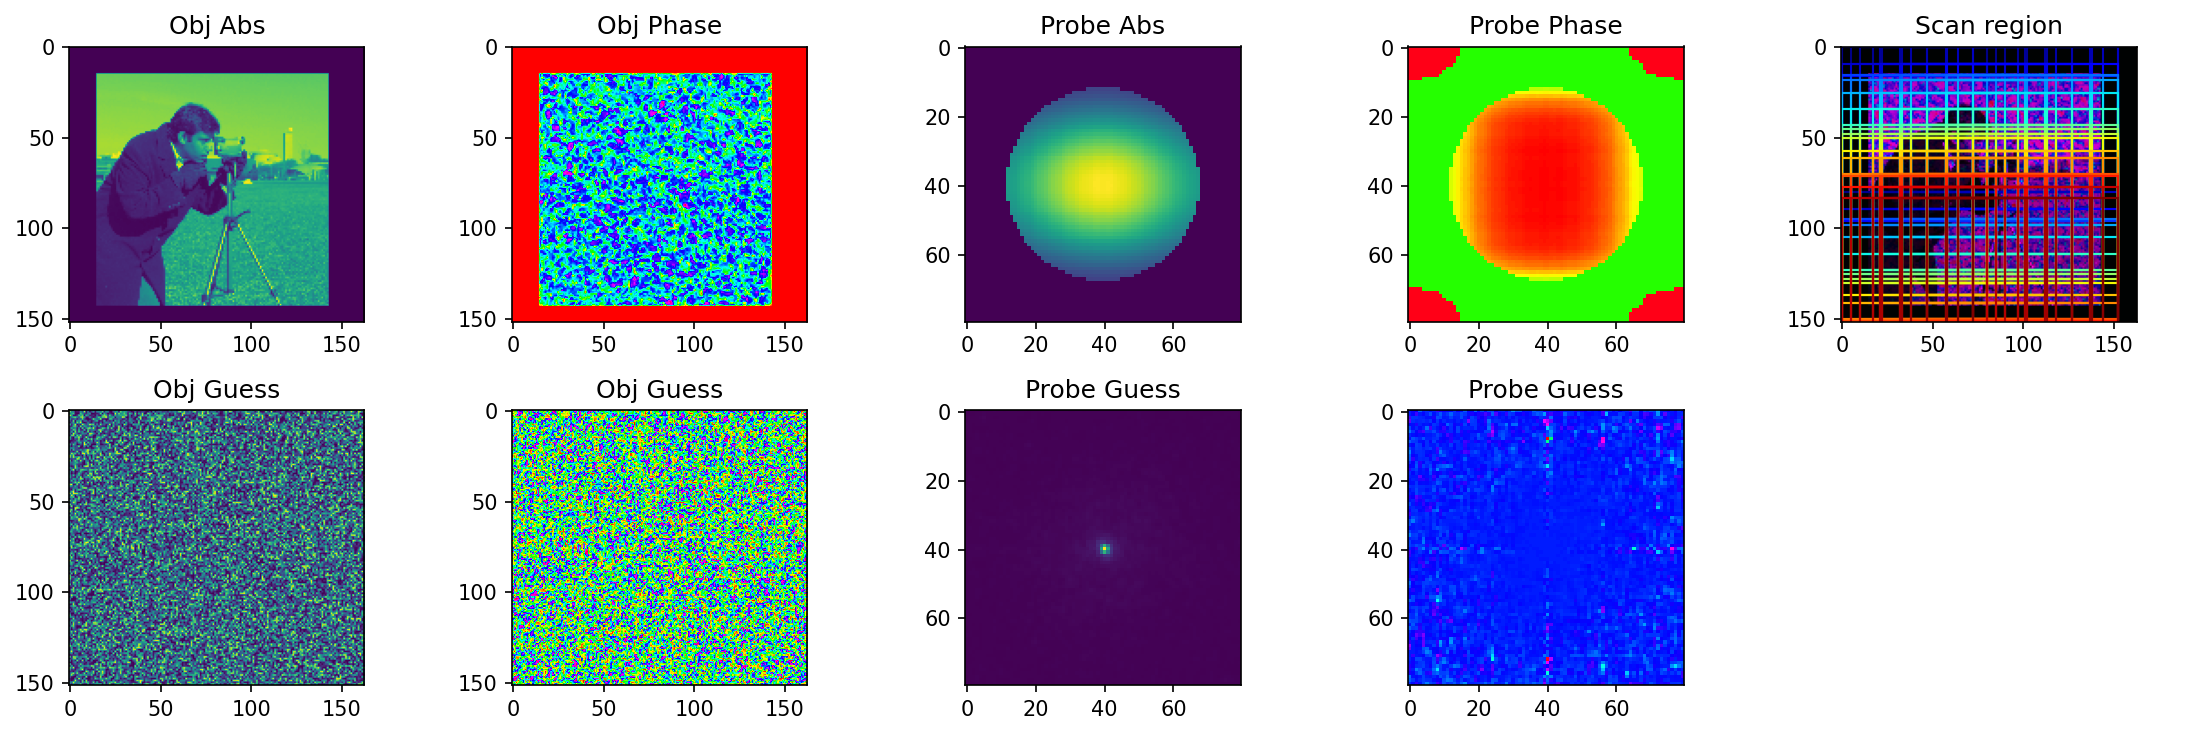

In [12]:
inputs = {
"path" : "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 100, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 10, #keV
"distance": 30, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [5,5], # pixels
"n_of_angles": 0
}

diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=True,add_position_errors=False,object_offset=15,dimension=80)

""" Experiment Parameters """
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
oversampling_ratio = wavelength*distance/(position_step*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ",oversampling_ratio)
experiment_params = dx, wavelength,distance

# probe_guess = model_probe 
probe_guess = get_circular_mask(model_probe.shape[0],0.3)
# probe_guess = np.ones_like(probe_guess) + 1j
ft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.mean(diffraction_patterns,axis=0))))
probe_guess = np.sqrt(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ft))))

obj_guess = np.ones_like(model_obj) # constant object
obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j


iterations = 200
n_of_modes = 1

# plot_positions_and_errors(data_folder,dataname,offset)
plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions)

Starting RAAR...
	Iteration 0/200
	Iteration 10/200
	Iteration 20/200
	Iteration 30/200
	Iteration 40/200
	Iteration 50/200
	Iteration 60/200
	Iteration 70/200
	Iteration 80/200
	Iteration 90/200
	Iteration 100/200
	Iteration 110/200
	Iteration 120/200
	Iteration 130/200
	Iteration 140/200
	Iteration 150/200
	Iteration 160/200
	Iteration 170/200
	Iteration 180/200
	Iteration 190/200
Starting RAAR multiprobe...
	Iteration 0/200 	Error: 2.26e+41
	Iteration 10/200 	Error: 2.44e+40
	Iteration 20/200 	Error: 1.81e+40
	Iteration 30/200 	Error: 1.55e+40
	Iteration 40/200 	Error: 1.38e+40
	Iteration 50/200 	Error: 1.22e+40
	Iteration 60/200 	Error: 1.08e+40
	Iteration 70/200 	Error: 9.64e+39
	Iteration 80/200 	Error: 8.63e+39
	Iteration 90/200 	Error: 7.74e+39
	Iteration 100/200 	Error: 6.95e+39
	Iteration 110/200 	Error: 6.27e+39
	Iteration 120/200 	Error: 5.65e+39
	Iteration 130/200 	Error: 5.10e+39
	Iteration 140/200 	Error: 4.60e+39
	Iteration 150/200 	Error: 4.15e+39
	Iteration 160/200 	E

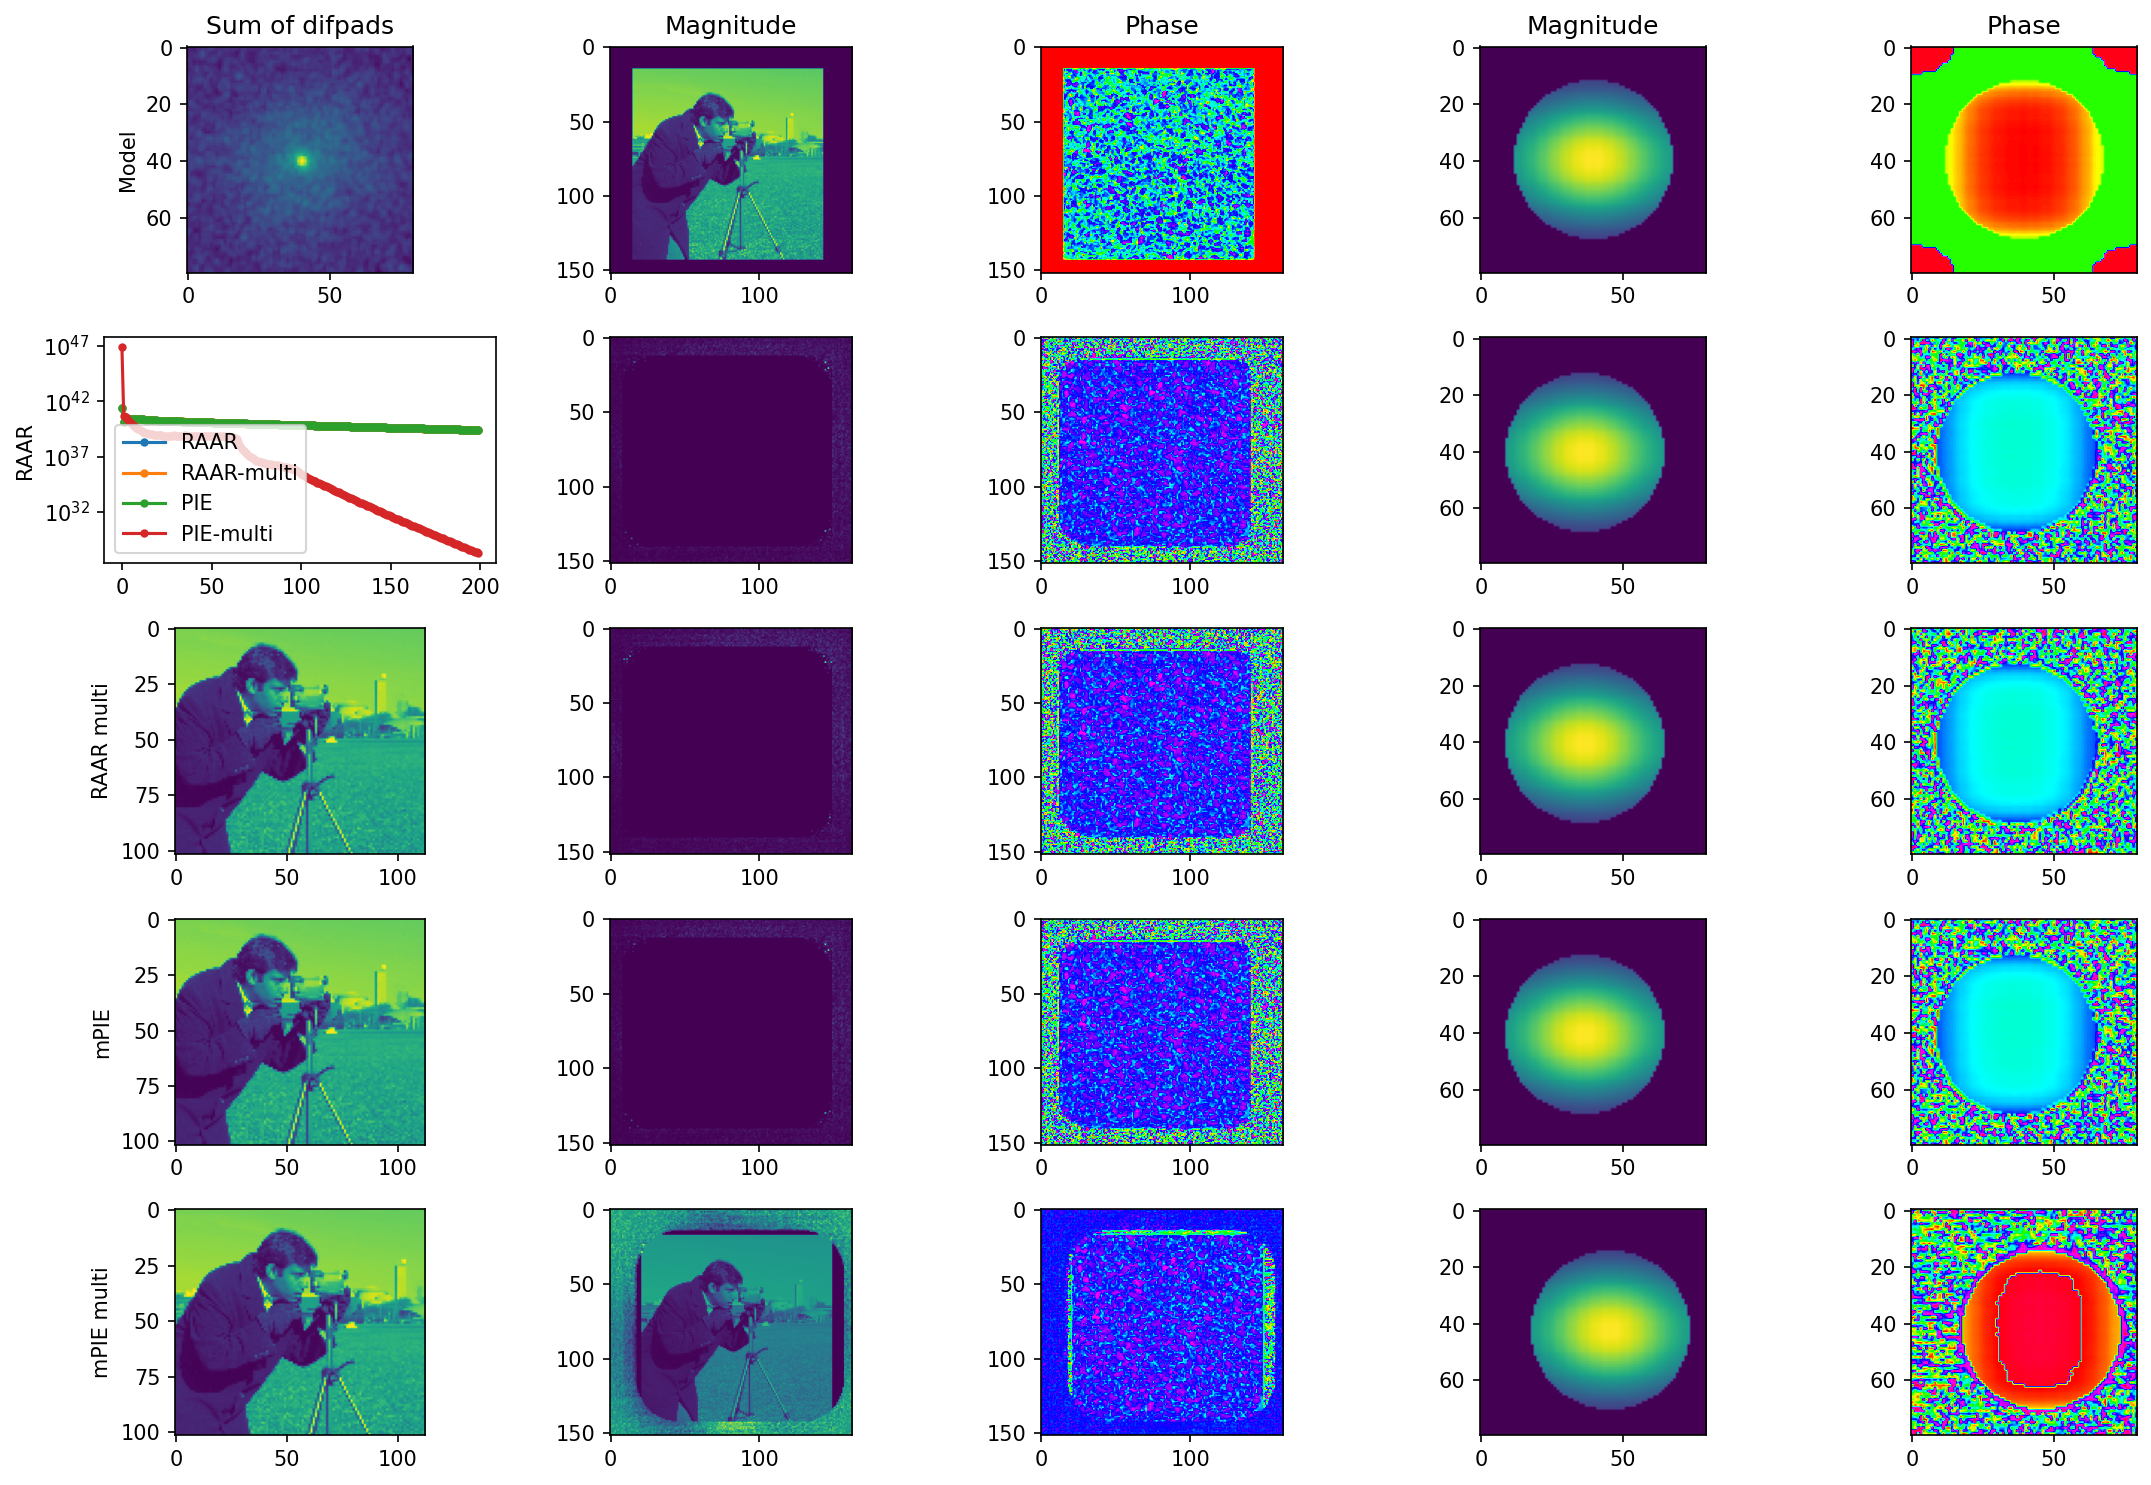

In [13]:
if 0: # suggested min from paper
    regularization_object, regularization_probe = 0.05, 0.5
    step_object, step_probe = 0.1, 0.2
    friction_object, friction_probe = 0.5, 0.75
    momentum_counter = 10
elif 1: # suggested max from paper
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 1
    friction_object, friction_probe = 0.9, 0.99
    momentum_counter = 100 
else: # my params
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 0.1
    friction_object, friction_probe = 0.9, 0
    momentum_counter = 100 

inputs['iterations'] = iterations    
    
inputs['object_pixel'] = dx
inputs['pixel_size'] = dx
inputs['wavelength'] = wavelength
inputs['distance'] = distance    

inputs['centralize_probe'] = False # not implemented 
inputs['regularization_object'] = regularization_object
inputs['regularization_probe']  = regularization_probe
inputs['step_object']= step_object
inputs['step_probe'] = step_probe
inputs['use_mPIE'] = False
inputs['friction_object'] = friction_object
inputs['friction_probe'] = friction_probe
inputs['momentum_counter'] = momentum_counter
inputs['position_correction_beta'] = 0 # if 0, does not apply position correction

inputs["n_of_modes"] = n_of_modes

inputs['beta'] = 0.995 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

if 0:
    """ mPIE """
    PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time, positions_story = mPIE_loop_cupy(diffraction_patterns, positions.copy(),obj_guess.copy(),probe_guess.copy(), inputs)

if 1: 
    """ RAAR """
    print('Starting RAAR...')
    RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess,inputs)


if 1:
    """ multiprobe RAAR """
    print('Starting RAAR multiprobe...')
    RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess,inputs)
    RAAR2_probe = RAAR2_probes[0]

if 1:
    """ multiprobe mPIE """
    PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions.copy(),obj_guess.copy(),probe_guess.copy(), inputs) 
    PIE2_obj = PIE2_obj[0]
    PIE2_probe = PIE2_multiprobe[0]


# PIE_error = PIE_error[1::]    
# RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = PIE_obj, PIE_probe, PIE_error, PIE_time # dummy copies
# RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time  = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time
PIE_obj, PIE_probe, PIE_error, PIE_time = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time 
# PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = PIE_obj, PIE_probe, PIE_error, PIE_time

plot_results3(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )

# plot_probe_modes(RAAR2_probes)
# plot_probe_modes(PIE2_multiprobe)

plt.show()

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from moviepy.editor import VideoClip, ImageSequenceClip
# from moviepy.video.io.bindings import mplfig_to_npimage
# from tqdm import tqdm

# obj = np.load('recon/object.npy')
# probe = np.load('recon/probe.npy')

# frame_rate = 30
# image_list = []

# abs_model_obj = np.abs(model_obj)
# angle_model_obj = np.angle(model_obj)
# abs_model_probe = np.abs(model_probe)
# angle_model_probe = np.angle(model_probe)

# abs_obj = np.abs(obj)
# angle_obj = np.angle(obj)
# abs_probe = np.abs(probe)
# angle_probe = np.angle(probe)

# for N in tqdm(range(obj.shape[0])):
# # for N in tqdm(range(100)):
#     # if N > 3000:
#         # break

#     if N > 500:
#         if N%20==0:
#             pass
#         else:
#             continue
#     else:
#         if N%2 == 0:
#             continue
        
#     animation_fig, ax = plt.subplots(2,4,figsize=(12,10),dpi=100)
#     ax[0,0].imshow(abs_model_obj,cmap='viridis')#,animated=True)
#     ax[0,1].imshow(angle_model_obj,cmap='viridis')#,animated=True)
#     ax[0,2].imshow(np.abs(model_probe),cmap='jet')#,animated=True)
#     ax[0,3].imshow(np.angle(model_probe),cmap='hsv')#,animated=True)

#     ax[1,0].imshow(abs_obj[N],cmap='viridis')#,animated=True)
#     ax[1,1].imshow(angle_obj[N],cmap='viridis')#,animated=True)
#     ax[1,2].imshow(abs_probe[N],cmap='jet')#,animated=True)
#     ax[1,3].imshow(angle_probe[N],cmap='hsv')#,animated=True)

#     ax[0,0].set_ylabel('Model')
#     ax[1,0].set_ylabel('mPIE')

#     ax[0,0].set_title('Magnitude')
#     ax[0,1].set_title('Phase')
#     ax[0,2].set_title('Magnitude')
#     ax[0,3].set_title('Phase')

#     for ax in ax.ravel():
#         ax.set_xticks([])
#         ax.set_yticks([])

#     image_list.append(mplfig_to_npimage(animation_fig))
#     plt.close()


# clip = ImageSequenceClip(image_list, fps=frame_rate)
# clip.write_videofile("movie.mp4",fps=frame_rate)